# Обучение классификатора с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными

In [ ]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gosha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('imdb')

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

D:\Notebooks\.venv_Pytorch\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gosha\.cache\huggingface\hub\datasets--imdb. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Расчёт числа слов в корпусе с помощью класса `Counter`.

In [7]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    proccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(proccessed_text):
        words[word] += 1

  0%|          | 0/25000 [00:00<?, ?it/s]

Создание словаря на основании частоты появления слова в корпусе.

In [12]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>']) #Служебные токены, использующиеся как индикаторы в последовательностях

counter_threshold = 25

for char, cnt in tqdm(words.items()):
    if cnt > counter_threshold:
        vocab.add(char)

  0%|          | 0/121222 [00:00<?, ?it/s]

Частота `25` определена эмпирически с целью получить адекватный размер словаря.

In [13]:
len(vocab)

11399

Методы для получения индексов токенов и получения токенов из индексов.

In [14]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

Создаётся класс `WordDataset` по типу `torch.Dataset` для облегчения работы с последовательностями. Классу такого типа необходимы **3** обязательных метода:

- `__init__` - конструктор;
- `__getitem__` - получение конкретного примера по индексу из датасета;
- `__len__` - метод определяющий длину датасета.

In [15]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)

Сбор последовательностей разных длин в ОДИН батч:

1. Получает на вход батч (список примеров из DataLoader по индексу список из `__getitem__`);
2. Все полученные последовательности собираются с учётом их длин;
3. Все данные переносятся в тензоры и в случае необходимости переносятся на устройство GPU/CPU.


In [20]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:

    # Определим максимальную длину последовательности, выбирая оптимум между заданной max_len и возможной самой большой длиной последовательности из текстов
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len] # Делаем truncate последовательности, ограничивая длину
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    # LongTensor содержит целочисленные индексы токенов
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }
    
    return new_batch

In [21]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 2000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Архитектура модели

In [22]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True) #batch_first = True, т.к. в DataLoader лежат батчи, а не сами предложения
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

## Train loop

In [24]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [25]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [26]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 0::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/196 [00:00<?, ?it/s]

Starting training for mean


Training epoch 0::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/196 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/196 [00:00<?, ?it/s]

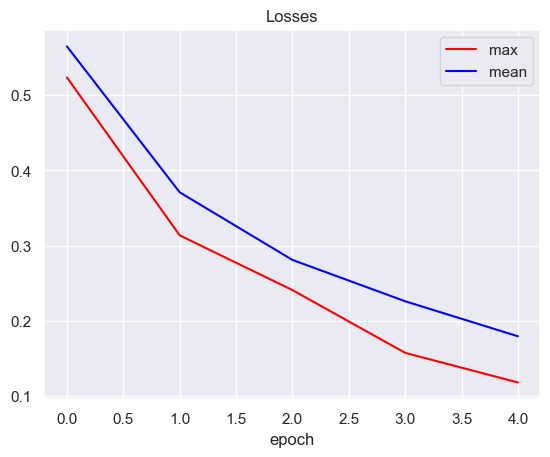

In [27]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 86.50
Лучшая accuracy для подхода mean: 85.95


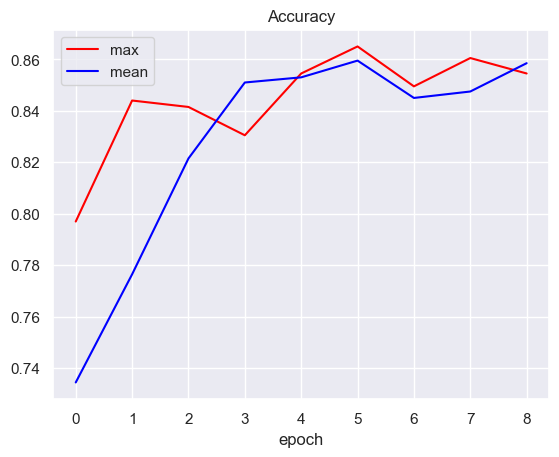

In [28]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [31]:
from torchviz import make_dot

In [ ]:
model()

In [39]:
train_dataset.data[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [43]:
with torch.no_grad():
    evaluate(model)

In [55]:
temp = next(iter(eval_dataloader))

In [57]:
temp['input_ids']

tensor([[ 4768,  6038, 10920,  ...,  2678,  2678,  2678],
        [ 4768,  5274,  6816,  ...,  2678,  2678,  2678],
        [ 4768,  2458,  3033,  ...,  2678,  2678,  2678],
        ...,
        [ 4768, 10873, 11245,  ...,  2678,  2678,  2678],
        [ 4768,  6442,     0,  ...,  7229, 11255, 11245],
        [ 4768,  2770, 11245,  ...,  3086, 11195,  1996]], device='cuda:0')

In [58]:
output = model(temp['input_ids'])

In [72]:
temp['input_ids'][0].shape

torch.Size([256])

In [74]:
model(torch.reshape(temp['input_ids'][0], (1, 256)))

tensor([[-1.0378,  0.9520]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [76]:
model.named_parameters

<bound method Module.named_parameters of CharLM(
  (embedding): Embedding(11399, 256)
  (rnn): RNN(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=2, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)>

In [77]:
torch.save(model.state_dict(), 'RNN1.pt')